In [137]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import seaborn as sns

from statannotations.Annotator import Annotator

figure_folder = 'figures'
os.makedirs(figure_folder, exist_ok=True)

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

subject = 'M15_5'
session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

for session_index, session_path in enumerate(session_paths):
    events = pd.read_csv(session_path)
    # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
    state_ids = np.where(events['state'] == 'state')[0]
    if len(state_ids) > 0:
        events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
        events['x'] = pd.to_numeric(events['x'])
        events['y'] = pd.to_numeric(events['y'])
        events['time'] = pd.to_numeric(events['time'])
        events['state'] = pd.to_numeric(events['state'])
        events['trial'] = pd.to_numeric(events['trial'])
        events['s_trial'] = pd.to_numeric(events['s_trial'])
        events['f_trial'] = pd.to_numeric(events['f_trial'])

    events['x'] = analog_to_digital(events['x'])
    events['y'] = analog_to_digital(events['y'])
    events['position'] = np.sqrt(events['x'] ** 2 + events['y'] ** 2)
    events['time'] = events['time'] - events['time'][0]
    events['time'] = events['time'] / n_ms_per_s 
    
    bin_scale = n_ms_per_s / 50 # smooth by bins
    events['binned_time'] = np.floor(events['time'] * bin_scale) / bin_scale
    binned_events = events[['binned_time', 'position']].groupby('binned_time').mean().reset_index().rename(columns={'position': 'binned_position'})

    # events['time'] = events['time'] / n_s_per_min
    events = events.merge(binned_events, on='binned_time', how='left')

    trial_starts, trial_ends = [], []
    for trial in range(n_total_trial):
        trial_indices = np.where(events['trial'] == trial)[0]
        trial_starts.append(trial_indices.min())
        trial_ends.append(trial_indices.max())

    break
events

,Date,time,trial,s_trial,f_trial,x,y,state,joystickX_offset,joystickY_offset,feed_water_amount,position,binned_time,binned_position
0,1713613046,0.000,0,0,0,0.023010,0.017257,0,2132,2140,0,0.028762,0.00,0.026606
1,1713613046,0.003,0,0,0,0.011505,-0.011505,0,2132,2140,0,0.016270,0.00,0.026606
2,1713613046,0.004,0,0,0,0.028762,0.000000,0,2132,2140,0,0.028762,0.00,0.026606
3,1713613046,0.005,0,0,0,0.034515,0.020133,0,2132,2140,0,0.039958,0.00,0.026606
4,1713613046,0.007,0,0,0,0.028762,0.011505,0,2132,2140,0,0.030978,0.00,0.026606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961261,1713614600,1554.396,99,20,79,-0.008629,-0.023010,3,2152,2151,6660,0.024574,1554.35,0.027017
961262,1713614600,1554.400,99,20,79,-0.017257,-0.014381,3,2152,2151,6660,0.022464,1554.40,0.027682
961263,1713614600,1554.401,99,20,79,-0.028762,-0.014381,3,2152,2151,6660,0.032157,1554.40,0.027682
961264,1713614600,1554.402,99,20,79,-0.008629,-0.008629,3,2152,2151,6660,0.012203,1554.40,0.027682


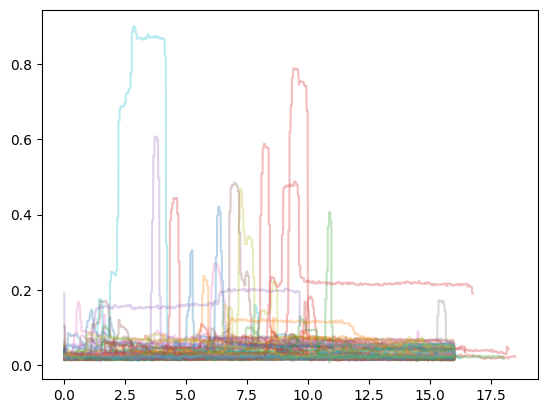

In [58]:
plt.figure()
for trial, (trial_start, tiral_end) in enumerate(zip(trial_starts, trial_ends)):
    plt.plot(events['time'][trial_start:tiral_end]-events['time'][trial_start], events['binned_position'][trial_start:tiral_end], alpha=0.3, label=trial)
plt.show()

In [81]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

half_successes = {}
successes = {}
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))
    successes[subject] = []
    half_successes[subject] = []
    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.

        half_successes[subject].append(events['s_trial'].tolist()[np.where(events['trial'] == (n_total_trial//2))[0][-1]]/(n_total_trial//2))
        successes[subject].append(events['s_trial'].tolist()[-1]/n_total_trial)

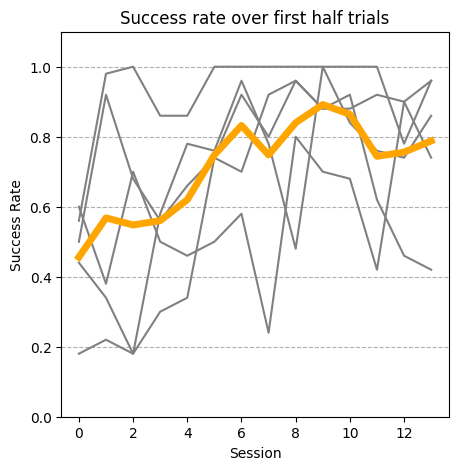

In [98]:
plt.figure(figsize=(5, 5))
all_half_successes = np.array([list(v) for v in half_successes.values()])
for subject, subject_successes in half_successes.items():
    plt.plot(subject_successes, label=subject, color='gray', linewidth=1.5)
plt.plot(all_half_successes.mean(axis=0), label='Mean', color='orange', linewidth=5)
plt.ylim(0, 1.1)
plt.title('Success rate over first half trials')
plt.xlabel('Session')
plt.ylabel('Success Rate')
plt.grid(True, axis='y', linestyle='--')
plt.show()

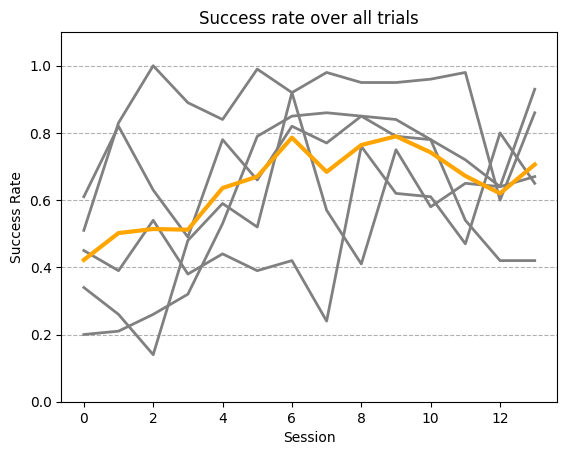

In [95]:
plt.figure()
all_successes = np.array([list(v) for v in successes.values()])
for subject, subject_successes in successes.items():
    plt.plot(subject_successes, label=subject, color='gray', linewidth=2)
plt.plot(all_successes.mean(axis=0), label='Mean', color='orange', linewidth=3)
plt.ylim(0, 1.1)
plt.title('Success rate over all trials')
plt.xlabel('Session')
plt.ylabel('Success Rate')
plt.grid(True, axis='y', linestyle='--')
plt.show()

In [69]:
successes

{'M15_2': [61, 82, 63, 49, 78, 66, 82, 77, 85, 84, 78, 54, 42, 42],
 'M15_3': [34, 26, 14, 48, 59, 52, 92, 57, 41, 75, 58, 65, 64, 67],
 'M15_5': [20, 21, 26, 32, 53, 79, 85, 86, 85, 79, 78, 72, 64, 93],
 'M15_7': [51, 83, 100, 89, 84, 99, 92, 98, 95, 95, 96, 98, 60, 86],
 'M16_1': [45, 39, 54, 38, 44, 39, 42, 24, 76, 62, 61, 47, 80, 65]}

In [138]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

half_successes = []
successes = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))
    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.

        half_successes.append({
            'rate': events['s_trial'].tolist()[np.where(events['trial'] == (n_total_trial//2))[0][-1]]/(n_total_trial//2),
            'subject': subject,
            'session': session_index+1,
        })
        successes.append({
            'rate': events['s_trial'].tolist()[-1]/n_total_trial,
            'subject': subject,
            'session': session_index+1,
        })
half_successes = pd.json_normalize(half_successes)
successes = pd.json_normalize(successes)

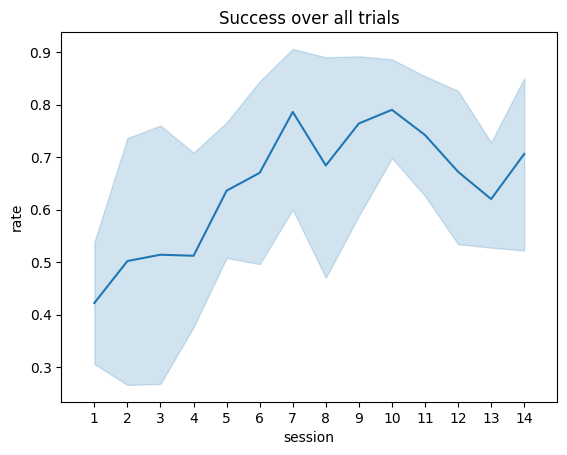

In [139]:
plt.figure()
sns.lineplot(data=successes, x='session', y='rate')#, hue='subject')
plt.title('Success over all trials')
plt.xlim(0, 15)
plt.xticks(np.arange(1, 15))
plt.savefig(f'{figure_folder}/rate_line.pdf')
plt.show()
plt.close()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 6: Welch's t-test independent samples, P_val:8.960e-02 t=-1.968e+00
1 vs. 10: Welch's t-test independent samples, P_val:3.782e-03 t=-4.134e+00
1 vs. 14: Welch's t-test independent samples, P_val:3.899e-02 t=-2.491e+00


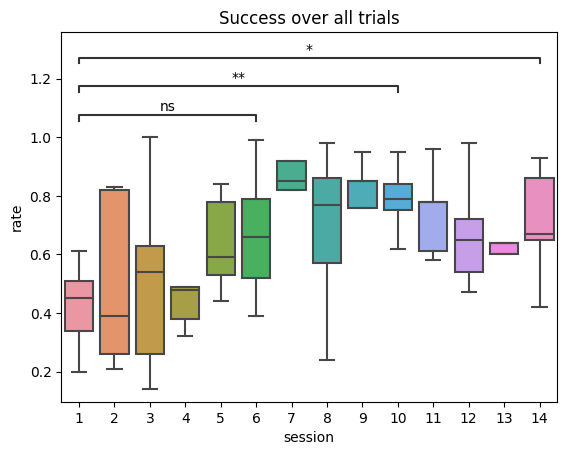

In [140]:
plt.figure()
ax = plt.gca()
sns.boxplot(data=successes, x='session', y='rate', showfliers=False, ax=ax)#, hue='subject')
plt.title('Success over all trials')
pairs = [(1, 6), (1, 10), (1, 14)]
annotator = Annotator(ax, pairs, data=successes, x='session', y='rate')
annotator.configure(test="t-test_welch").apply_and_annotate()
plt.savefig(f'{figure_folder}/rate_box.pdf')
plt.show()
plt.close()